In [1]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2021-03-05 05:08:56--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2021-03-05 05:08:56--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2021-03-05 05:08:56--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... conne

In [3]:
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [5]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    # n은 샘플 개수입니다
    # 한 줄에 10개씩 이미지를 그립니다. 샘플 개수를 10으로 나누어 전체 행 개수를 계산합니다. 
    rows = int(np.ceil(n/10))
    # 행이 1개 이면 열 개수는 샘플 개수입니다. 그렇지 않으면 10개입니다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

# **PCA**
*PCA:2개의 특성을 한개의 주성분으로 표현해 데이터의 차원수를 줄이는 알고리즘

In [4]:
from sklearn.decomposition import PCA

#n_components:찾을 주성분 개수
#주어진 데이터는 100*100의 픽셀이므로 이를 가로지르는 벡터 50개가 주성분의 개수로 충분하다.
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
print(fruits.shape)
print(pca.components_.reshape(-1, 100, 100).shape)

(300, 100, 100)
(50, 100, 100)


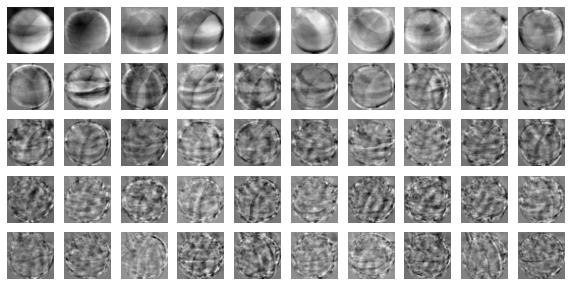

In [7]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [13]:
#transform메소드는 주어진 넘파이데이터의 특성을 주성분으로 변환해준다.
#아래는 각 과일의 사진을 50개의 특성으로 표현된 것을 확인할 수 있다.
fruits_pca = pca.transform(fruits_2d)
print(fruits_2d.shape)
print(fruits_pca.shape)

(300, 10000)
(300, 50)


**원본 데이터 재구성**

In [14]:
#inverse_transform메소드는 pca모델로 변환된 넘파이 배열을 다시 원본데이터로 일부 복원해준다.
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


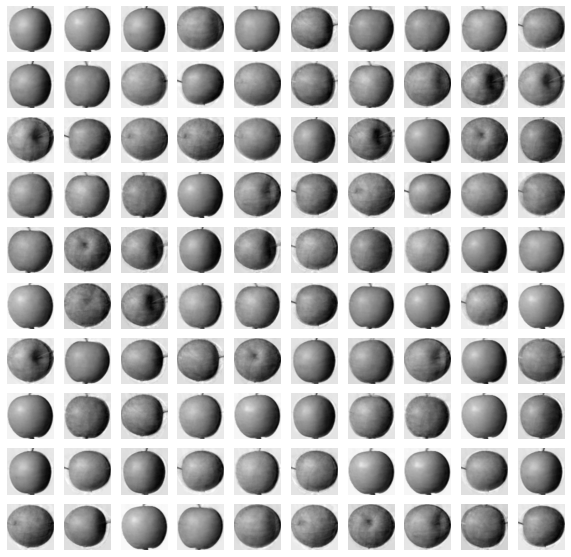

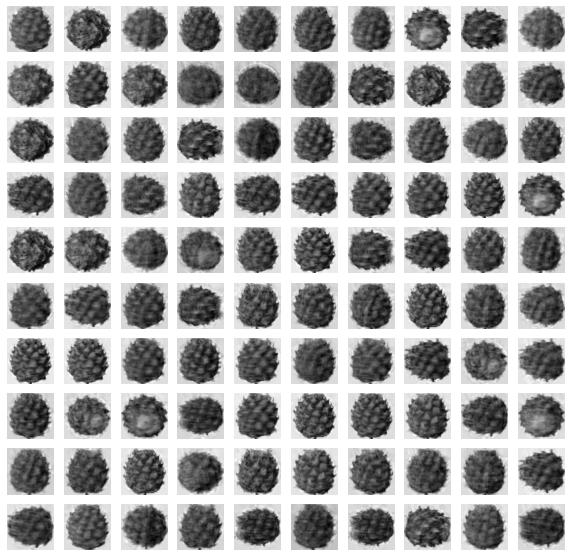

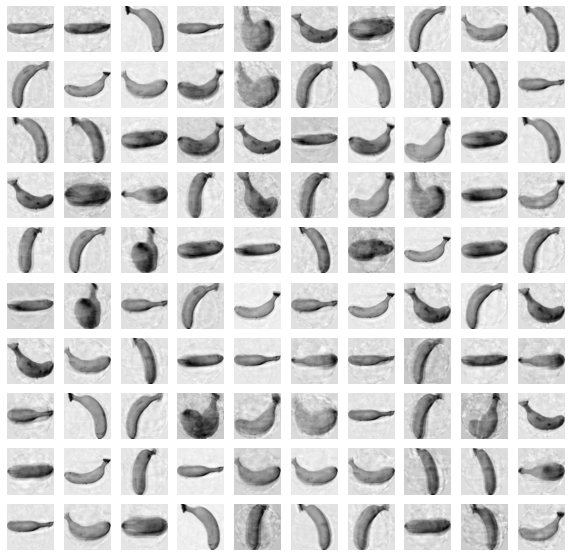

In [15]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

**설명된 분산**

*설명된 분산이란, pca알고리즘으로 찾은 주성분이 원본데이터를 어느정도까지 표현할 수 있는가를 말한다

In [16]:
print(np.sum(pca.explained_variance_ratio_))
#이 pca모델은 보이는 바와 같이 원본 데이터의 92퍼센트를 표현하였음을 알 수 있다.

0.9215462827856366


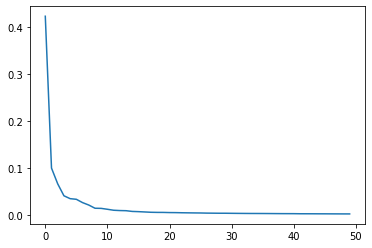

In [17]:
plt.plot(pca.explained_variance_ratio_)

**로지스트 회귀에 적용**

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
#타깃 세트 구성.
#0:사과
#1:파인애플
#2:바나나
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [20]:
from sklearn.model_selection import cross_validate

#원본데이터 그대로 학습
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
1.4367916107177734


In [21]:
#pca알고리즘으로 주성분만 학습
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))
#테스트점수는 별반 차이없음에 비해 학습시간이 압도적으로 빨라졌음을 볼 수 있다.

1.0
0.03067889213562012


In [23]:
#n_components 매개변수로 설명된 분산의 비율, 즉 원본데이터를 몇 퍼센트만큼이나 나타낼건지도 정할 수 있다.
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)
print(pca.n_components_)
#아래와 같이 원본데이터의 50퍼센트를 표현하는데 드는 주성분의 개수는 단 2개밖에 필요하지 않다는 것을 알 수 있다.

2


In [24]:
fruits_pca = pca.transform(fruits_2d)
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))
#2개의 주성분만 사용했음에도 높은 테스트 점수를 얻은것을 볼 수 있다.

0.9933333333333334
0.047637224197387695


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


**KMeans에 적용**

In [25]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [26]:
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([ 91,  99, 110]))


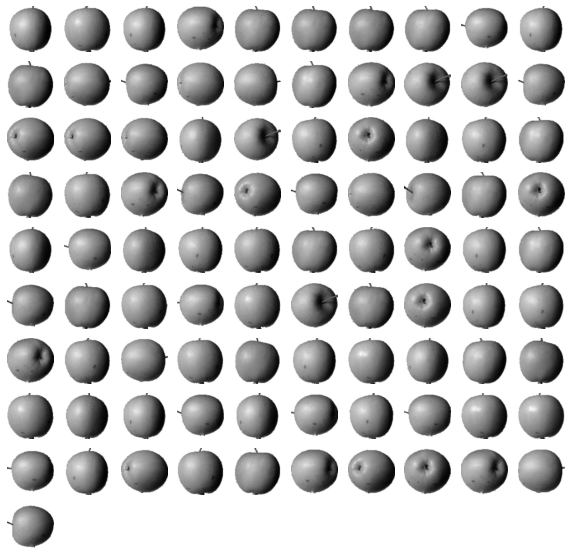

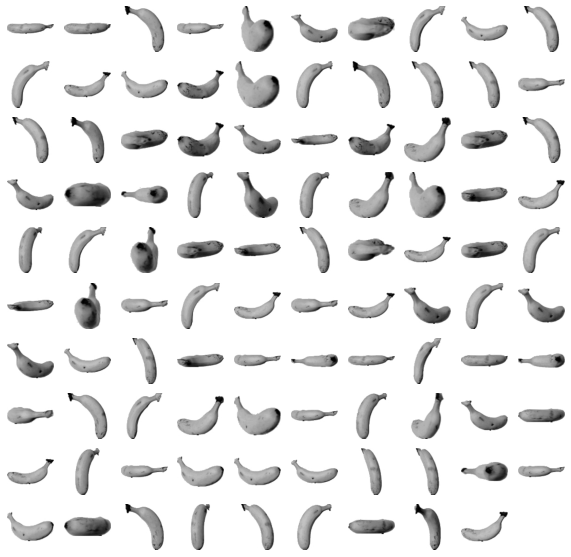

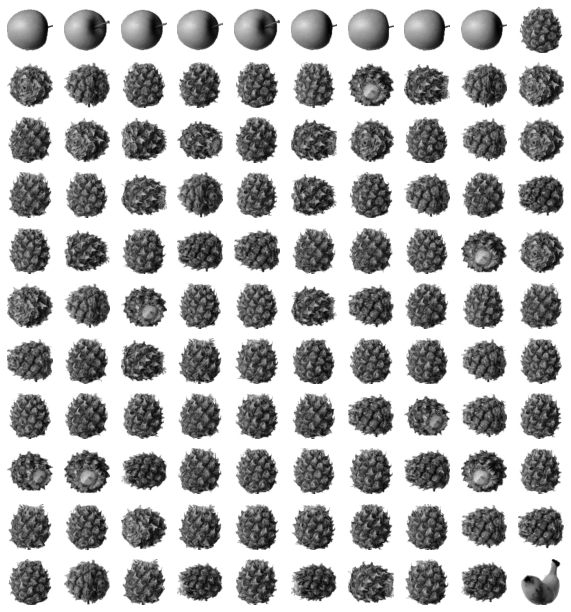

In [27]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

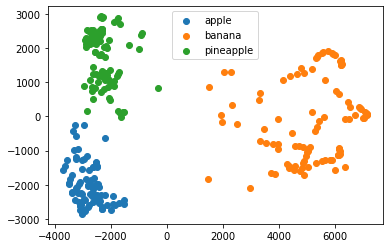

In [28]:
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()
#두개의 특성만을 사용했기에 평면 좌표계에 나타내는게 가능해진다.